<a href="https://colab.research.google.com/github/kangjunseo/DeepLearning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing ResNet 18

In [14]:
from typing import List

import torch
import torch.nn as nn
from torch import Tensor
import torch.backends.cudnn as cudnn
import torch.optim as optim

import os

## Overall architecture of ResNet

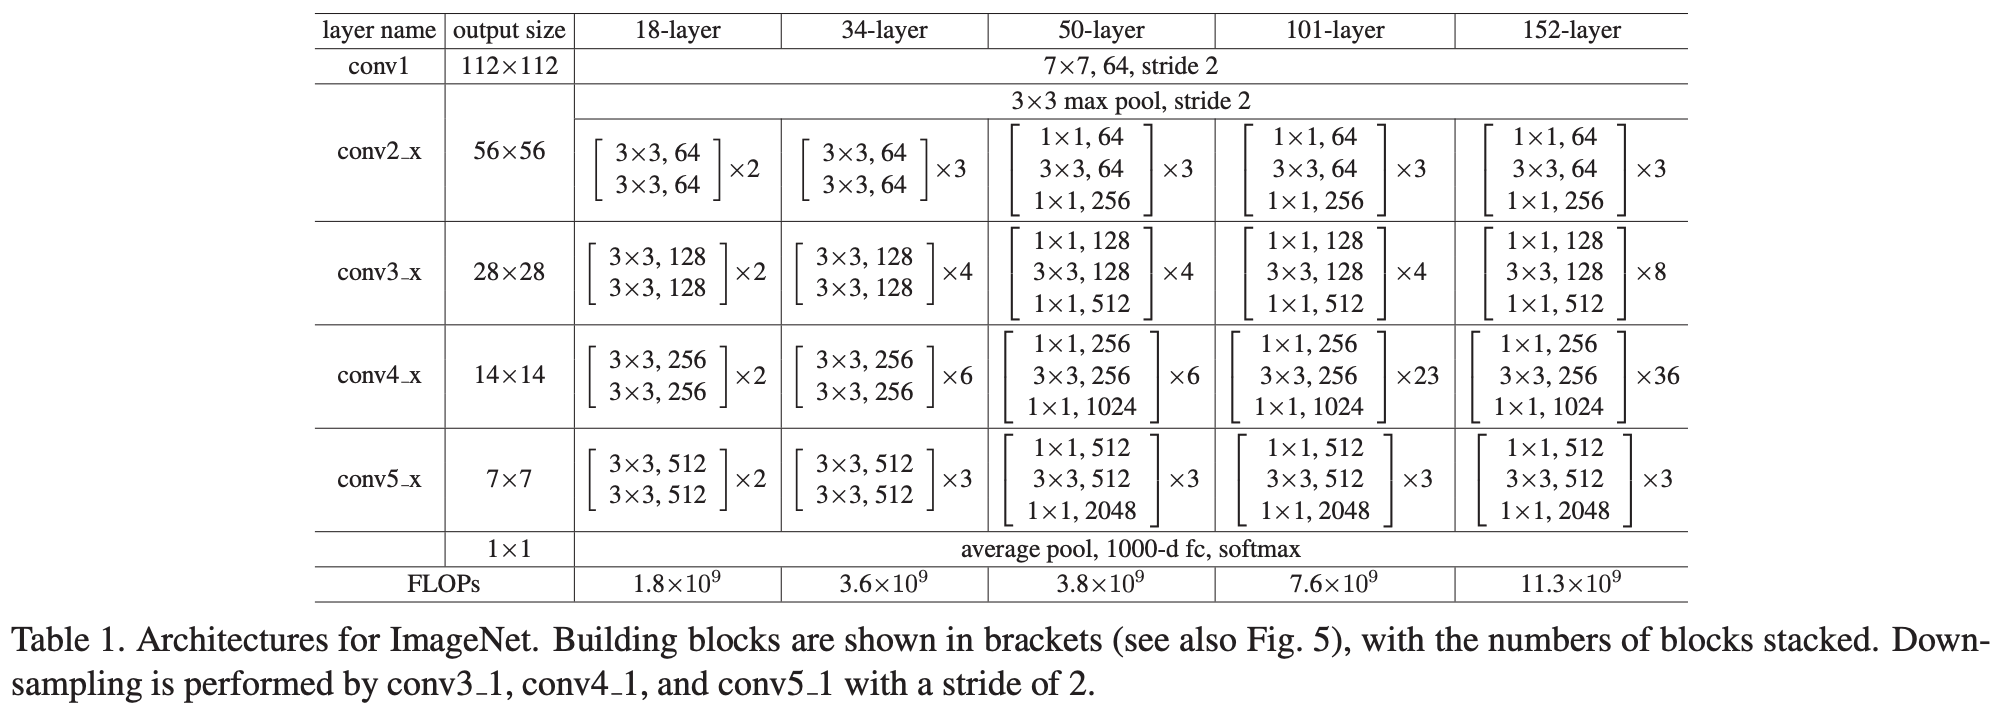

In [26]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, padding: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=False
    )


class BasicBlock(nn.Module):
    def __init__(
        self, 
        in_planes: int, 
        planes: int, 
        stride: int = 1
    ) -> None:
        super().__init__()

        #self.conv1 = conv3x3(in_planes, planes, stride) # 3x3 filter
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # batch normalization
        self.relu = nn.ReLU(inplace=True)
        # self.conv2 = conv3x3(planes, planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) 

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        
        # conv1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # conv2
        out = self.conv2(x)
        out = self.bn2(out)

        out += identity # key point of ResNet
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: BasicBlock,
        layers: List[int],
        num_classes: int = 10, # use only 10-d instead of 1000-d
     ) -> None:
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 3x3 maxpool, stride 2
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(
        self,
        block: BasicBlock,
        planes: int,
        blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
      
        layers = []
        layers.append(
              block(
                  self.in_planes, planes, stride
              )
          )
        for i in range(1, blocks):
            layers.append(
                block(
                    self.in_planes, planes
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # conv1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # conv2,3,4,5
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # average pool & linear
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

# Dataset Loading

In [17]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)
     

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Setting environments

In [27]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training

In [28]:
for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)


[ Train epoch: 0 ]


RuntimeError: ignored

# References
[ndb796's implementation of ResNet18]

https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/ResNet18_CIFAR10_Train.ipynb

[resnet source of pytorch]

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py